In [8]:
# Setup
!pip install --quiet --upgrade pip

# Install the dependencies.
!pip install --quiet -r requirements_tf.txt

# Restart the runtime by ending the process.
exit()

In [1]:
import os
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
import google.auth
from importlib import reload
from serving.constants import  BUCKET, IMG_SOURCE_PREFIX, HIST_DEST_PREFIX, NUM_BANDS, HIST_BINS_LIST, SCALE, CROP, MONTHS, IMAGE_BATCH, NUM_BINS
from serving.common import list_blobs_with_prefix
from serving.hist_training import create_hist_dataset, create_data_sample, get_labels, LstmModel, load_dataset_from_gcp, save_dataset_to_gcp, TimeDependentDenseLstmModel
from serving.data import check_blob_prefix_exists, batch_check_blobs, get_varied_labels
import logging
import io
import itertools
from google.cloud import storage
import google.auth
import time

from keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt

In [2]:
# SETUP

#####
CREATE_DATASET = False
#####

start_time = time.perf_counter()
credentials, _ = google.auth.default()
bucket_name = BUCKET
directory_prefix = IMG_SOURCE_PREFIX
output_prefix = HIST_DEST_PREFIX
labels_data = "labels_combined.npy"
labels_header = "labels_header.npy"
batch_size = 32

client = storage.Client()
bucket = client.get_bucket(bucket_name)
num_bins = 128 * 2
img_range = [0,2500]

In [3]:
file_name = f"{num_bins}_buckets_training_test" #"hist_dataset_medium" #
dataset_suffix = r".tfrecords"

file_name += dataset_suffix


if CREATE_DATASET:
    # Generate all prefixes
    start_time = time.perf_counter()
    
    labels_df = get_varied_labels(*img_range)
    labels = list(zip(labels_df["county_name"],
                      labels_df["county_ansi"],
                 labels_df["state_ansi"],
                 labels_df["year"]))


    prefixes_hist = [f'histograms/{num_bins}_buckets/{SCALE}/{county.capitalize()}_{fips}/{year}' 
                for county,_, fips, year in labels]

    # Batch check all prefixes
    results_hist = batch_check_blobs(bucket_name, prefixes_hist)

    # Generate get_input_img_params based on results
    get_input_img_params = [(county.capitalize(), fips, year)
                for county, county_fips, fips, year in labels
                if results_hist[f'histograms/{num_bins}_buckets/{SCALE}/{county.capitalize()}_{fips}/{year}']
    ]

    print(f"Number of items to process: {len(get_input_img_params)}")
    
    end_time_dataset_info = time.perf_counter()
    print(f"Collecting dataset information: {end_time_dataset_info-start_time}")
    
    dataset, input_shape = create_hist_dataset(get_input_img_params, "labels_combined.npy", "labels_header.npy", num_bins=num_bins)
    end_time_dataset = time.perf_counter()
    
    print(f"Building dataset: {(end_time_dataset - end_time_dataset_info)/60:.02} minutes")
    
    # Save dataset
    save_dataset_to_gcp(dataset, file_name = file_name)
    print("Dataset created")
    CREATE_DATASET = False
else:
    dataset = load_dataset_from_gcp(file_name=file_name)
    for features, label in dataset.take(1):
        input_shape = tuple(features.shape)
        label_shape = label.shape
    print("Dataset loaded")

Dataset loaded


In [4]:
# Sample labels
label_data = np.load(labels_data, allow_pickle=True)
label_header = np.load(labels_header, allow_pickle=True)
label_df = pd.DataFrame(label_data, columns=label_header)
label_df[label_df["county_name"]=='Sutter'.upper()]

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,target,source_file
66,CORN,YEAR,2016,06,CALIFORNIA,101,SUTTER,264.1,USDA_Corn_County_2016.csv
3045,CORN,YEAR,2018,06,CALIFORNIA,101,SUTTER,210.0,USDA_Corn_County_2018.csv
4389,CORN,YEAR,2019,06,CALIFORNIA,101,SUTTER,147.1,USDA_Corn_County_2019.csv
7314,CORN,YEAR,2021,06,CALIFORNIA,101,SUTTER,169.9,USDA_Corn_County_2021.csv
8791,CORN,YEAR,2022,06,CALIFORNIA,101,SUTTER,133.8,USDA_Corn_County_2022.csv


In [ ]:
model = TimeDependentDenseLstmModel(input_shape=input_shape, lstm_layers=4, dense_layers_per_step=4, no_units=2, mean_response=0)
model.compile(optimizer='nadam', learning_rate = 0.05)
history = model.fit(dataset, epochs=30, batch_size=batch_size)

Epoch 1/30
113/113 [==============================] - 28s 241ms/step - loss: 20613.9688 - mae: 137.8386 - val_loss: 18499.5820 - val_mae: 130.1965
Epoch 2/30
113/113 [==============================] - 27s 229ms/step - loss: 16287.7490 - mae: 121.1423 - val_loss: 15413.9424 - val_mae: 117.9286
Epoch 3/30
113/113 [==============================] - 27s 231ms/step - loss: 12818.6387 - mae: 105.9756 - val_loss: 11464.2109 - val_mae: 99.7005
Epoch 4/30
113/113 [==============================] - 27s 230ms/step - loss: 10053.4170 - mae: 92.2128 - val_loss: 8759.1689 - val_mae: 84.7326
Epoch 5/30
113/113 [==============================] - 27s 233ms/step - loss: 7817.4771 - mae: 79.7606 - val_loss: 6764.5229 - val_mae: 73.5505
Epoch 6/30
113/113 [==============================] - 27s 230ms/step - loss: 6099.8350 - mae: 69.0544 - val_loss: 5446.6558 - val_mae: 64.1096
Epoch 7/30
113/113 [==============================] - 27s 234ms/step - loss: 4759.6724 - mae: 59.7851 - val_loss: 4152.7817 - val_

147.03702
Epoch 1/25
113/113 [==============================] - 13s 107ms/step - loss: 16752.9277 - mae: 122.3050 - val_loss: 10554.4043 - val_mae: 96.5848
Epoch 2/25
113/113 [==============================] - 13s 107ms/step - loss: 7539.3271 - mae: 77.5996 - val_loss: 5025.3560 - val_mae: 59.7328
Epoch 3/25
113/113 [==============================] - 13s 106ms/step - loss: 3477.4360 - mae: 49.9933 - val_loss: 2354.9373 - val_mae: 40.5966
Epoch 4/25
113/113 [==============================] - 13s 108ms/step - loss: 2059.9534 - mae: 37.9667 - val_loss: 1901.4015 - val_mae: 37.1905
Epoch 5/25
113/113 [==============================] - 13s 107ms/step - loss: 1681.9325 - mae: 34.1315 - val_loss: 1574.7385 - val_mae: 32.4935
Epoch 6/25
113/113 [==============================] - 13s 108ms/step - loss: 1605.1124 - mae: 33.0721 - val_loss: 1603.8984 - val_mae: 32.2412
Epoch 7/25
113/113 [==============================] - 13s 108ms/step - loss: 1603.5938 - mae: 32.9379 - val_loss: 1538.4626 - val

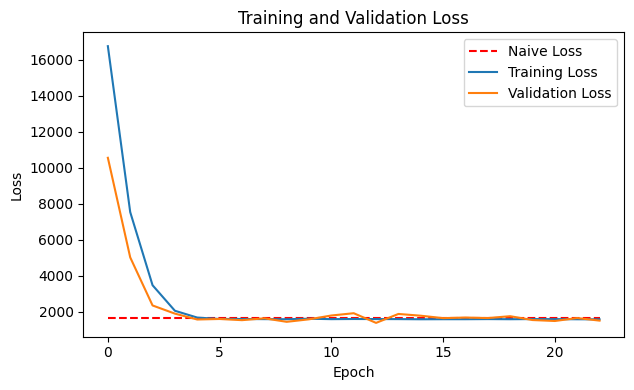

7/7 [==============================] - 1s 37ms/step - loss: 1586.1229 - mae: 32.4257


In [4]:
responses = []
for _, response in dataset:
    responses.append(response.numpy())
mean_response = np.mean(responses)
print(mean_response)

model = LstmModel(input_shape=input_shape, lstm_layers=4, no_units=2, mean_response=0)
model.compile(optimizer='nadam', learning_rate = 0.5)
history = model.fit(dataset, epochs=25, batch_size=batch_size)

In [5]:
print(model.naive_loss)

1636.5499


In [7]:
%load_ext tensorboard
%tensorboard --logdir gs://vgnn/tensorboard-artifacts/logs/fit/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
 %reload_ext tensorboard